# Multistage newsvendor problem

## SDDP and Stochastic Decomposition methods


### Problema (2 stages)

Se desea resolver:

$$\min E[p_1 u_1 + p_2 u_2 + p_3 u_3]$$

sujeto a:

$$x_1 = x_0 + u_1,$$
$$x_1+u_2\geqslant w_1,$$
$$x_2 = x_1 + u_2 - w_1,$$
$$x_2 + u_3 \geqslant w_2.$$

In [1]:
using Distributions, JuMP, Gurobi, Plots, ProgressMeter, StatsBase
gurobi_env = Gurobi.Env()

Academic license - for non-commercial use only - expires 2021-11-06


Gurobi.Env(Ptr{Nothing} @0x000000000385fd40, false, 0)

In [2]:
function piecewise_linear(x,cuts)
    
    return maximum([cut[1]+cut[2]*x for cut in cuts])
end

piecewise_linear (generic function with 1 method)

In [3]:
p1 = 1.0 #day ahead price
p2 = 2.0 #first day price
p3 = 4.0 #last day price

#condicion inicial de stock
x0=0.0;

In [4]:
#array de vectores de cuts. Arranca en la lower bound
cuts1 = [[0.0;0.0]];
cuts2 = [[0.0;0.0]];


## Implemento SDDP a mano
@showprogress 1 for i=1:100
    
    ## FORWARD PASS
    #resuelvo el primer paso
    model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))
    @variable(model,u1>=0);
    @variable(model,x1>=0);
    @variable(model,z);

    @constraint(model,x1==x0+u1)
    
    for i=1:length(cuts1)
        cut=cuts1[i]
        @constraint(model,z>=cut[1]+cut[2]*x1);
    end

    
    @objective(model,Min,p1*u1+z);

    optimize!(model)

    global x1v = value.(x1);

    #sorteo una demanda de primer paso
    demand = rand(DiscreteUniform(0,100))
    
    #resuelvo el segundo paso
    model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))
    @variable(model,u2>=0);
    @variable(model,x2>=0);
    @variable(model,z);

    @constraint(model,x2==x1v-demand+u2)
    
    for i=1:length(cuts2)
        cut=cuts2[i]
        @constraint(model,z>=cut[1]+cut[2]*x2);
    end

    @objective(model,Min,p2*u2+z);

    optimize!(model)

    global x2v = value.(x2);
    
    println("x1:$x1v, x2: $x2v")
    ### BACKWARD PASS
    
    #resuelvo para todos los ruidos el ultimo paso y agrego un corte
    local_cuts = [];

    for demand=(0:100)
        
        model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

        @variable(model,u3>=0);
        @variable(model,x2>=0);

        @constraint(model,x2+u3-demand>=0);
        fix_x2 = @constraint(model,x2==x2v);

        @objective(model,Min,p3*u3);

        optimize!(model)

        beta = objective_value(model);
        lambda = dual(fix_x2)
        #println("fix_x2=$lambda")
        push!(local_cuts,[beta-lambda*x2v;lambda])

    end
    push!(cuts2,mean(local_cuts))
    
    
    #resuelvo para todos los ruidos el segundo paso y agrego un corte
    local_cuts = [];

    for demand=(0:100)
        
        model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

        @variable(model,u2>=0);
        @variable(model,x1>=0);
        @variable(model,z);

        @constraint(model,x1+u2-demand>=0);
        fix_x1 = @constraint(model,x1==x1v);

        for i=1:length(cuts2)
            cut=cuts2[i]
            @constraint(model,z>=cut[1]+cut[2]*(x1+u2-demand));
        end

        @objective(model,Min,p2*u2+z);

        optimize!(model)

        beta = objective_value(model);
        lambda = dual(fix_x1)
        #println("fix_x1=$lambda")
        push!(local_cuts,[beta-lambda*x1v;lambda])

    end
    push!(cuts1,mean(local_cuts))
    
    
end

x1:0.0, x2: 0.0
x1:100.5, x2: 74.5


Progress:   2%|▉                                        |  ETA: 0:17:04

x1:137.34756193782553, x2: 93.34756193782553
x1:118.89350081922466, x2: 37.5
x1:134.14905390931838, x2: 81.14905390931838
x1:126.19326683291783, x2: 102.19326683291783
x1:121.94221105527663, x2: 55.99999999999999
x1:133.79946524064124, x2: 80.79946524064124
x1:127.8177339901477, x2: 61.8177339901477
x1:124.22727272727252, x2: 123.22727272727252
x1:125.99999999999972, x2: 74.99999999999972
x1:125.09493670886053, x2: 111.09493670886053
x1:124.77570093457892, x2: 69.77570093457892
x1:121.74402730375415, x2: 102.74402730375415
x1:123.19801980198073, x2: 103.19801980198073


Progress:  15%|██████▏                                  |  ETA: 0:02:13

x1:123.99999999999918, x2: 60.999999999999176
x1:124.27027027027106, x2: 99.27027027027106
x1:124.69565217391518, x2: 106.69565217391518
x1:124.50000000000398, x2: 88.50000000000398
x1:123.11111111111107, x2: 47.0
x1:129.201596806386, x2: 100.201596806386
x1:126.36138613861354, x2: 51.99999999999999
x1:123.76470588234902, x2: 79.76470588234902
x1:125.03802281368802, x2: 49.999999999999964


Progress:  24%|█████████▉                               |  ETA: 0:01:19

x1:123.59602649006338, x2: 105.59602649006338
x1:124.50000000000043, x2: 59.500000000000426
x1:125.15686274509893, x2: 79.15686274509893
x1:125.00000000000038, x2: 120.00000000000038
x1:125.00000000000038, x2: 48.999999999999794
x1:127.17948717948565, x2: 61.17948717948565


Progress:  30%|████████████▎                            |  ETA: 0:01:01

x1:126.23039215686322, x2: 109.23039215686322
x1:125.72815533980612, x2: 64.72815533980612
x1:124.78260869565383, x2: 49.99999999999982
x1:125.17821782178228, x2: 53.17821782178228
x1:124.97101449275362, x2: 65.97101449275362
x1:125.0869565217406, x2: 73.0869565217406


Progress:  36%|██████████████▊                          |  ETA: 0:00:48

x1:124.90163934426417, x2: 97.90163934426417
x1:125.21052631579082, x2: 100.21052631579082
x1:125.00000000000365, x2: 96.00000000000365
x1:124.96721311475568, x2: 89.96721311475568
x1:125.09836065573865, x2: 49.99999999999982
x1:125.00000000000111, x2: 49.99999999999982


Progress:  42%|█████████████████▎                       |  ETA: 0:00:39

x1:125.00000000000111, x2: 49.99999999999982
x1:125.00000000000111, x2: 121.00000000000111
x1:125.00000000000111, x2: 100.00000000000111
x1:125.00000000000111, x2: 60.00000000000111
x1:125.00000000000111, x2: 124.00000000000111


Progress:  47%|███████████████████▎                     |  ETA: 0:00:33

x1:125.00000000000111, x2: 69.00000000000111
x1:125.00000000000111, x2: 99.00000000000111
x1:125.00000000000111, x2: 49.99999999999982
x1:125.00000000000111, x2: 73.00000000000111
x1:125.00000000000111, x2: 85.00000000000111


Progress:  52%|█████████████████████▍                   |  ETA: 0:00:28

x1:124.60000000000129, x2: 49.99999999999982
x1:125.00000000000007, x2: 67.00000000000007
x1:125.10526315789662, x2: 108.10526315789662
x1:125.0000000000005, x2: 93.0000000000005
x1:125.0000000000005, x2: 49.99999999999982


Progress:  57%|███████████████████████▍                 |  ETA: 0:00:24

x1:125.0000000000005, x2: 119.0000000000005
x1:125.0000000000005, x2: 62.0000000000005
x1:125.33333333335825, x2: 49.99999999999982
x1:126.00000000000962, x2: 97.00000000000962
x1:125.74257425742611, x2: 51.742574257426114


Progress:  62%|█████████████████████████▍               |  ETA: 0:00:20

x1:125.47999999999725, x2: 49.99999999999982
x1:124.99999999999689, x2: 118.99999999999689
x1:124.99999999999673, x2: 73.99999999999673
x1:124.99999999999673, x2: 103.99999999999673
x1:124.99999999999673, x2: 59.99999999999673


Progress:  67%|███████████████████████████▌             |  ETA: 0:00:17

x1:124.99999999999673, x2: 72.99999999999673
x1:124.99999999999673, x2: 116.99999999999673
x1:124.99999999999673, x2: 89.99999999999673
x1:125.03703703703422, x2: 57.037037037034224


Progress:  71%|█████████████████████████████▏           |  ETA: 0:00:14

x1:124.96428571428451, x2: 82.96428571428451
x1:125.03278688524482, x2: 84.03278688524482
x1:124.96825396825196, x2: 78.96825396825196
x1:125.0307692307669, x2: 111.0307692307669
x1:124.9999999999993, x2: 49.99999999999982


Progress:  76%|███████████████████████████████▏         |  ETA: 0:00:11

x1:124.9999999999993, x2: 76.9999999999993
x1:125.03225806451788, x2: 58.032258064517876
x1:125.00000000000132, x2: 102.00000000000132
x1:125.00000000000132, x2: 49.99999999999982


Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:09

x1:125.00000000000132, x2: 110.00000000000132
x1:125.00000000000132, x2: 108.00000000000132
x1:125.00000000000132, x2: 73.00000000000132
x1:125.00000000000132, x2: 49.99999999999982


Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:07

x1:125.00000000000132, x2: 112.00000000000132
x1:125.00000000000132, x2: 116.00000000000132
x1:125.00000000000132, x2: 71.00000000000132
x1:124.93548387097056, x2: 109.93548387097056


Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:05

x1:125.0000000000014, x2: 114.0000000000014
x1:125.0000000000014, x2: 111.0000000000014
x1:125.0000000000014, x2: 60.00000000000141
x1:125.0000000000014, x2: 91.0000000000014


Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:04

x1:124.97014925373034, x2: 87.97014925373034
x1:125.03174603174598, x2: 88.03174603174598
x1:124.99999999999964, x2: 87.99999999999964
x1:124.99999999999964, x2: 49.99999999999982


Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:02

x1:124.99999999999964, x2: 103.99999999999964
x1:124.99999999999964, x2: 121.99999999999964
x1:124.99999999999964, x2: 49.99999999999982
x1:124.99999999999964, x2: 74.99999999999964


Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


In [5]:
cuts1

101-element Vector{Vector{Float64}}:
 [0.0, 0.0]
 [201.0, -2.0]
 [170.64434859327528, -1.2424272130183318]
 [85.28252132143906, -0.524458386432703]
 [158.9520635231841, -1.0736202333104599]
 [119.26693461425357, -0.7591412606607196]
 [139.92138025683764, -0.9175571022448781]
 [158.51093030095086, -1.0524458386432707]
 [127.98804038819723, -0.8136457210077448]
 [144.04352514459364, -0.9359866679737283]
 [152.41799823546708, -1.0024507401235176]
 [148.54288795216152, -0.9714733849622589]
 [149.80041172434073, -0.9814724046662096]
 ⋮
 [152.36584648563868, -0.998137437506127]
 [152.36584648563868, -0.998137437506127]
 [152.36584648563868, -0.998137437506127]
 [152.41525340652882, -0.9985295559258898]
 [153.95961180276447, -1.0108812861484169]
 [152.46466032741893, -0.9989216743456525]
 [153.69003038917756, -1.0087246348397216]
 [153.69003038917756, -1.0087246348397216]
 [153.69003038917756, -1.0087246348397216]
 [153.69003038917756, -1.0087246348397216]
 [153.73904519164793, -1.00911675325

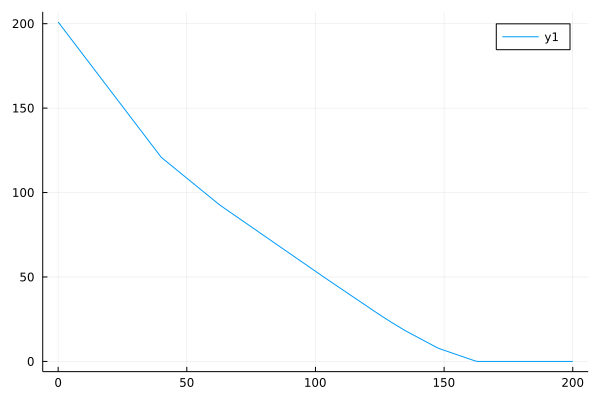

In [6]:
x=(0:200.0)

plot(x,piecewise_linear.(x,Ref(cuts1)))

In [7]:
cuts2

101-element Vector{Vector{Float64}}:
 [0.0, 0.0]
 [200.0, -3.9603960396039604]
 [90.0990099009901, -1.0297029702970297]
 [26.89108910891089, -0.27722772277227725]
 [172.15841584158414, -2.495049504950495]
 [68.47524752475248, -0.7524752475247525]
 [0.0, 0.0]
 [136.79207920792078, -1.7425742574257426]
 [71.68316831683168, -0.7920792079207921]
 [125.10891089108911, -1.5445544554455446]
 [0.0, 0.0]
 [87.12871287128714, -0.9900990099009901]
 [0.0, 0.0]
 ⋮
 [0.0, 0.0]
 [0.0, 0.0]
 [127.52475247524752, -1.5841584158415842]
 [34.21782178217822, -0.3564356435643564]
 [48.396039603960396, -0.5148514851485149]
 [44.91089108910891, -0.4752475247524752]
 [44.91089108910891, -0.4752475247524752]
 [149.5049504950495, -1.9801980198019802]
 [0.0, 0.0]
 [0.0, 0.0]
 [149.5049504950495, -1.9801980198019802]
 [87.12871287128714, -0.9900990099009901]

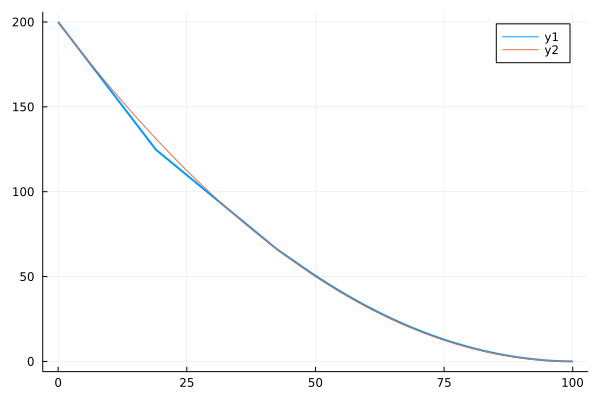

In [8]:
x=(0:100.0)

plot(x,piecewise_linear.(x,Ref(cuts2)),lw=2)
plot!(x,p3*(100 .-x).^2/200)

In [9]:
x1v,x2v

(124.99999999999964, 74.99999999999964)

## Stochastic cutting plane

In [10]:
#array de vectores de cuts. Arranca en la lower bound
cuts1 = [[0.0;0.0]];
cuts2 = [[0.0;0.0]];

noises1 = Float64[]
noises2 = Float64[]


## Implemento SDDP a mano
@showprogress 1 for i=1:300
    
    ## FORWARD PASS
    #resuelvo el primer paso
    model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))
    @variable(model,u1>=0);
    @variable(model,x1>=0);
    @variable(model,z);

    @constraint(model,x1==x0+u1)
    
    for i=1:length(cuts1)
        cut=cuts1[i]
        @constraint(model,z>=cut[1]+cut[2]*x1);
    end

    
    @objective(model,Min,p1*u1+z);

    optimize!(model)

    global x1v = value.(x1);

    #sorteo una demanda de primer paso
    demand1 = rand(DiscreteUniform(0,100))
    push!(noises1,demand1)
    #resuelvo el segundo paso
    model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))
    @variable(model,u2>=0);
    @variable(model,x2>=0);
    @variable(model,z);

    @constraint(model,x2==x1v-demand1+u2)
    
    for i=1:length(cuts2)
        cut=cuts2[i]
        @constraint(model,z>=cut[1]+cut[2]*x2);
    end

    @objective(model,Min,p2*u2+z);

    optimize!(model)

    global x2v = value.(x2);
    
    println("x1:$x1v, x2: $x2v")
    
    ### BACKWARD PASS
    
    #sorteo la segunda demanda
    demand2 = rand(DiscreteUniform(0,100))
    push!(noises2,demand2)
    
    #resuelvo para todos los ruidos el ultimo paso y agrego un corte
    local_cuts = [];

    for i=1:length(noises2)
        
        demand2 = noises2[i]
        
        model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

        @variable(model,u3>=0);
        @variable(model,x2>=0);

        @constraint(model,x2+u3-demand2>=0);
        fix_x2 = @constraint(model,x2==x2v);

        @objective(model,Min,p3*u3);

        optimize!(model)

        beta = objective_value(model);
        lambda = dual(fix_x2)
        #println("fix_x2=$lambda")
        push!(local_cuts,[beta-lambda*x2v;lambda])
    end

    cuts2 = (i-1)/i * cuts2
    push!(cuts2,mean(local_cuts))
    
    
    for i=1:length(noises1)
        
        #resuelvo para todos los ruidos el segundo paso y agrego un corte
        local_cuts = [];

    
        demand1 = noises1[i]
        
        model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

        @variable(model,u2>=0);
        @variable(model,x1>=0);
        @variable(model,z);

        @constraint(model,x1+u2-demand1>=0);
        fix_x1 = @constraint(model,x1==x1v);

        for i=1:length(cuts2)
            cut=cuts2[i]
            @constraint(model,z>=cut[1]+cut[2]*(x1+u2-demand1));
        end

        @objective(model,Min,p2*u2+z);

        optimize!(model)

        beta = objective_value(model);
        lambda = dual(fix_x1)
        #println("fix_x1=$lambda")
        push!(local_cuts,[beta-lambda*x1v;lambda])

    end
    cuts1 = (i-1)/i * cuts1
    push!(cuts1,mean(local_cuts))    
    
end

x1:0.0, x2: 0.0
x1:55.0, x2: 29.0
x1:101.0, x2: 53.0
x1:143.0, x2: 120.0
x1:143.0, x2: 60.0
x1:173.99999999999997, x2: 160.99999999999997
x1:173.99999999999997, x2: 99.99999999999997
x1:173.99999999999994, x2: 156.99999999999994
x1:173.99999999999994, x2: 149.99999999999994
x1:0.0, x2: 0.0
x1:124.62500000000006, x2: 98.62500000000006
x1:124.62500000000004, x2: 67.62500000000004
x1:124.62500000000007, x2: 49.62500000000007
x1:137.11111111111114, x2: 102.11111111111114
x1:137.11111111111117, x2: 70.11111111111117
x1:137.75000000000006, x2: 72.75000000000006
x1:137.75000000000003, x2: 37.75000000000003
x1:173.6153846153846, x2: 135.6153846153846
x1:173.61538461538464, x2: 78.61538461538464


Progress:   7%|██▉                                      |  ETA: 0:00:14

x1:183.00000000000003, x2: 159.00000000000003
x1:183.00000000000003, x2: 87.00000000000003
x1:160.42857142857142, x2: 75.42857142857142
x1:160.42857142857142, x2: 94.42857142857142
x1:160.42857142857142, x2: 160.42857142857142
x1:160.42857142857142, x2: 114.42857142857142
x1:160.4285714285714, x2: 75.42857142857139
x1:163.74999999999994, x2: 98.74999999999994
x1:163.74999999999994, x2: 152.74999999999994
x1:163.74999999999997, x2: 88.74999999999997
x1:163.74999999999994, x2: 109.74999999999994
x1:163.75, x2: 137.75
x1:163.74999999999997, x2: 65.74999999999997
x1:179.27272727272728, x2: 163.27272727272728
x1:179.27272727272728, x2: 90.27272727272728
x1:179.27272727272725, x2: 114.27272727272725
x1:179.27272727272725, x2: 137.27272727272725
x1:179.27272727272722, x2: 149.27272727272722
x1:179.27272727272725, x2: 114.27272727272725


Progress:  13%|█████▍                                   |  ETA: 0:00:14

x1:179.2727272727272, x2: 111.2727272727272
x1:179.27272727272725, x2: 147.27272727272725
x1:179.27272727272722, x2: 157.27272727272722
x1:179.27272727272722, x2: 169.27272727272722
x1:179.27272727272722, x2: 161.27272727272722
x1:179.27272727272722, x2: 119.27272727272722
x1:179.2727272727272, x2: 169.2727272727272
x1:179.2727272727272, x2: 178.2727272727272
x1:179.2727272727272, x2: 115.2727272727272
x1:179.27272727272722, x2: 165.27272727272722
x1:179.27272727272725, x2: 126.27272727272725
x1:179.27272727272722, x2: 79.27272727272722
x1:190.07142857142856, x2: 146.07142857142856
x1:190.07142857142853, x2: 155.07142857142853
x1:190.07142857142856, x2: 119.07142857142856
x1:190.07142857142858, x2: 96.07142857142858
x1:189.66666666666669, x2: 166.66666666666669
x1:189.6666666666667, x2: 112.66666666666671


Progress:  19%|███████▋                                 |  ETA: 0:00:16

x1:0.0, x2: 0.0
x1:110.82922824302133, x2: 67.82922824302133
x1:110.82922824302136, x2: 92.82922824302136
x1:110.82922824302135, x2: 37.82922824302135
x1:112.76136363636367, x2: 101.76136363636367
x1:112.76136363636368, x2: 105.76136363636368
x1:112.76136363636367, x2: 54.27272727272722
x1:115.87500000000001, x2: 37.666666666666565
x1:148.44444444444449, x2: 144.44444444444449
x1:148.4444444444445, x2: 109.44444444444451


Progress:  22%|█████████                                |  ETA: 0:00:18

x1:148.44444444444454, x2: 128.44444444444454
x1:148.44444444444454, x2: 141.44444444444454
x1:148.44444444444454, x2: 133.44444444444454
x1:148.44444444444454, x2: 81.44444444444454
x1:148.4444444444445, x2: 140.4444444444445
x1:148.4444444444445, x2: 145.4444444444445
x1:148.44444444444457, x2: 124.44444444444457
x1:148.44444444444457, x2: 63.44444444444457


Progress:  25%|██████████▏                              |  ETA: 0:00:19

x1:148.44444444444457, x2: 84.44444444444457
x1:148.44444444444457, x2: 92.44444444444457
x1:148.44444444444454, x2: 128.44444444444454
x1:148.44444444444454, x2: 130.44444444444454
x1:148.44444444444454, x2: 86.44444444444454
x1:148.4444444444445, x2: 66.44444444444451
x1:148.44444444444454, x2: 148.44444444444454


Progress:  27%|███████████▏                             |  ETA: 0:00:20

x1:148.4444444444445, x2: 141.4444444444445
x1:148.4444444444445, x2: 112.44444444444451
x1:148.44444444444449, x2: 98.44444444444449
x1:148.44444444444449, x2: 57.444444444444485
x1:158.43478260869566, x2: 118.43478260869566
x1:158.43478260869563, x2: 107.43478260869563


Progress:  29%|███████████▉                             |  ETA: 0:00:21

x1:158.43478260869568, x2: 65.43478260869568
x1:167.56250000000003, x2: 120.56250000000003
x1:167.56250000000003, x2: 151.56250000000003
x1:167.56250000000003, x2: 93.56250000000003


Progress:  30%|████████████▍                            |  ETA: 0:00:22

x1:167.56250000000006, x2: 136.56250000000006
x1:167.56250000000003, x2: 96.56250000000003
x1:167.56250000000006, x2: 161.56250000000006
x1:167.56250000000006, x2: 132.56250000000006


Progress:  32%|█████████████                            |  ETA: 0:00:23

x1:167.56250000000006, x2: 166.56250000000006
x1:167.56250000000006, x2: 137.56250000000006
x1:167.56250000000006, x2: 73.56250000000006
x1:171.6666666666667, x2: 79.66666666666671
x1:171.66666666666669, x2: 97.66666666666669


Progress:  33%|█████████████▋                           |  ETA: 0:00:24

x1:171.66666666666674, x2: 101.66666666666674
x1:171.66666666666674, x2: 129.66666666666674
x1:171.66666666666674, x2: 152.66666666666674
x1:171.66666666666677, x2: 100.66666666666677
x1:171.66666666666677, x2: 120.66666666666677


Progress:  35%|██████████████▍                          |  ETA: 0:00:25

x1:171.66666666666677, x2: 80.66666666666677
x1:171.66666666666677, x2: 137.66666666666677
x1:171.6666666666668, x2: 144.6666666666668
x1:171.6666666666668, x2: 121.6666666666668


Progress:  36%|██████████████▉                          |  ETA: 0:00:25

x1:171.66666666666683, x2: 167.66666666666683
x1:171.66666666666683, x2: 94.66666666666683
x1:171.66666666666683, x2: 138.66666666666683
x1:171.66666666666686, x2: 133.66666666666686


Progress:  38%|███████████████▌                         |  ETA: 0:00:25

x1:171.66666666666686, x2: 113.66666666666686
x1:171.66666666666686, x2: 94.66666666666686
x1:171.66666666666686, x2: 117.66666666666686
x1:171.66666666666688, x2: 73.66666666666688


Progress:  39%|████████████████                         |  ETA: 0:00:26

x1:181.47619047619057, x2: 103.47619047619057
x1:181.4761904761906, x2: 104.4761904761906
x1:181.47619047619057, x2: 139.47619047619057
x1:181.47619047619054, x2: 152.47619047619054


Progress:  40%|████████████████▌                        |  ETA: 0:00:26

x1:181.47619047619048, x2: 144.47619047619048
x1:181.47619047619048, x2: 123.47619047619048
x1:181.47619047619048, x2: 102.47619047619048
x1:181.4761904761905, x2: 92.47619047619051


Progress:  42%|█████████████████▏                       |  ETA: 0:00:27

x1:181.47619047619054, x2: 170.47619047619054
x1:181.47619047619054, x2: 130.47619047619054
x1:181.47619047619057, x2: 96.47619047619057
x1:181.47619047619057, x2: 136.47619047619057


Progress:  43%|█████████████████▋                       |  ETA: 0:00:27

x1:181.47619047619057, x2: 102.47619047619057
x1:181.4761904761906, x2: 142.4761904761906
x1:181.47619047619057, x2: 139.47619047619057
x1:181.47619047619057, x2: 148.47619047619057


Progress:  44%|██████████████████▏                      |  ETA: 0:00:27

x1:181.47619047619057, x2: 166.47619047619057
x1:181.4761904761906, x2: 152.4761904761906
x1:181.4761904761906, x2: 172.4761904761906


Progress:  45%|██████████████████▋                      |  ETA: 0:00:27

x1:181.4761904761906, x2: 110.4761904761906
x1:181.47619047619065, x2: 177.47619047619065
x1:181.4761904761906, x2: 148.4761904761906


Progress:  46%|███████████████████                      |  ETA: 0:00:27

x1:181.47619047619062, x2: 106.47619047619062
x1:181.47619047619062, x2: 175.47619047619062
x1:0.0, x2: 0.0


Progress:  47%|███████████████████▍                     |  ETA: 0:00:28

x1:77.54035639412993, x2: 40.67924528301888
x1:115.21271646420257, x2: 64.22641509433964
x1:115.21271646420254, x2: 83.21271646420254


Progress:  48%|███████████████████▉                     |  ETA: 0:00:28

x1:115.2127164642026, x2: 101.2127164642026
x1:115.21271646420263, x2: 100.21271646420263
x1:115.21271646420266, x2: 113.21271646420266


Progress:  49%|████████████████████▎                    |  ETA: 0:00:28

x1:115.21271646420266, x2: 69.21271646420266
x1:115.21271646420267, x2: 105.21271646420267
x1:115.21271646420266, x2: 85.21271646420266


Progress:  50%|████████████████████▋                    |  ETA: 0:00:28

x1:115.21271646420271, x2: 54.03448275862075
x1:126.07879924953102, x2: 122.07879924953102
x1:126.07879924953099, x2: 80.07879924953099


Progress:  51%|█████████████████████                    |  ETA: 0:00:28

x1:126.07879924953097, x2: 95.07879924953097
x1:126.07879924953096, x2: 64.19230769230771
x1:154.06019151846783, x2: 146.06019151846783


Progress:  52%|█████████████████████▌                   |  ETA: 0:00:28

x1:154.0601915184678, x2: 132.0601915184678
x1:154.06019151846783, x2: 147.06019151846783
x1:154.06019151846783, x2: 70.06019151846783


Progress:  53%|█████████████████████▉                   |  ETA: 0:00:28

x1:154.06019151846783, x2: 112.06019151846783
x1:154.06019151846786, x2: 109.06019151846786
x1:154.06019151846783, x2: 118.06019151846783


Progress:  54%|██████████████████████▎                  |  ETA: 0:00:28

x1:154.0601915184678, x2: 116.0601915184678
x1:154.0601915184678, x2: 77.0601915184678
x1:154.0601915184678, x2: 148.0601915184678


Progress:  55%|██████████████████████▋                  |  ETA: 0:00:28

x1:154.06019151846786, x2: 118.06019151846786
x1:154.06019151846786, x2: 110.06019151846786
x1:154.06019151846783, x2: 88.06019151846783


Progress:  56%|███████████████████████▏                 |  ETA: 0:00:28

x1:154.06019151846783, x2: 80.06019151846783
x1:154.06019151846786, x2: 117.06019151846786
x1:154.0601915184679, x2: 101.06019151846789


Progress:  57%|███████████████████████▌                 |  ETA: 0:00:28

x1:154.06019151846795, x2: 93.06019151846795
x1:154.06019151846792, x2: 100.06019151846792


Progress:  58%|███████████████████████▊                 |  ETA: 0:00:28

x1:154.0601915184679, x2: 107.06019151846789
x1:154.0601915184679, x2: 61.06019151846789


Progress:  59%|████████████████████████                 |  ETA: 0:00:28

x1:165.88372093023258, x2: 116.88372093023258
x1:165.8837209302326, x2: 87.88372093023261


Progress:  59%|████████████████████████▍                |  ETA: 0:00:28

x1:165.8837209302326, x2: 148.8837209302326
x1:165.8837209302326, x2: 89.88372093023261


Progress:  60%|████████████████████████▋                |  ETA: 0:00:28

x1:165.88372093023264, x2: 144.88372093023264
x1:165.88372093023258, x2: 159.88372093023258


Progress:  61%|████████████████████████▉                |  ETA: 0:00:28

x1:165.88372093023258, x2: 101.88372093023258
x1:165.88372093023264, x2: 128.88372093023264


Progress:  61%|█████████████████████████▏               |  ETA: 0:00:28

x1:165.88372093023267, x2: 68.88372093023267
x1:179.63636363636363, x2: 103.63636363636363


Progress:  62%|█████████████████████████▍               |  ETA: 0:00:28

x1:179.63636363636365, x2: 91.63636363636365
x1:179.63636363636363, x2: 82.63636363636363


Progress:  63%|█████████████████████████▊               |  ETA: 0:00:28

x1:173.3928571428571, x2: 130.3928571428571
x1:173.39285714285717, x2: 166.39285714285717


Progress:  63%|██████████████████████████               |  ETA: 0:00:28

x1:173.39285714285717, x2: 85.39285714285717
x1:173.39285714285717, x2: 169.39285714285717


Progress:  64%|██████████████████████████▎              |  ETA: 0:00:28

x1:173.39285714285714, x2: 77.39285714285714
x1:173.39285714285717, x2: 138.39285714285717


Progress:  65%|██████████████████████████▌              |  ETA: 0:00:27

x1:173.39285714285717, x2: 87.39285714285717
x1:173.39285714285717, x2: 86.39285714285717


Progress:  65%|██████████████████████████▊              |  ETA: 0:00:27

x1:173.39285714285717, x2: 78.39285714285717
x1:173.39285714285714, x2: 76.39285714285714


Progress:  66%|███████████████████████████              |  ETA: 0:00:27

x1:177.05882352941168, x2: 89.05882352941168
x1:177.05882352941163, x2: 175.05882352941163


Progress:  67%|███████████████████████████▍             |  ETA: 0:00:27

x1:177.05882352941163, x2: 173.05882352941163
x1:177.0588235294116, x2: 96.0588235294116


Progress:  67%|███████████████████████████▋             |  ETA: 0:00:27

x1:177.0588235294116, x2: 173.0588235294116
x1:177.0588235294116, x2: 164.0588235294116


Progress:  68%|███████████████████████████▉             |  ETA: 0:00:27

x1:177.05882352941157, x2: 172.05882352941157
x1:177.05882352941157, x2: 157.05882352941157


Progress:  69%|████████████████████████████▏            |  ETA: 0:00:27

x1:177.0588235294115, x2: 106.05882352941151
x1:177.05882352941146, x2: 83.05882352941146


Progress:  69%|████████████████████████████▍            |  ETA: 0:00:26

x1:177.0588235294114, x2: 170.0588235294114
x1:177.0588235294114, x2: 126.0588235294114


Progress:  70%|████████████████████████████▊            |  ETA: 0:00:26

x1:177.05882352941146, x2: 167.05882352941146
x1:177.05882352941148, x2: 123.05882352941148


Progress:  71%|█████████████████████████████            |  ETA: 0:00:26

x1:177.05882352941154, x2: 117.05882352941154
x1:177.0588235294115, x2: 125.05882352941151


Progress:  71%|█████████████████████████████▎           |  ETA: 0:00:26

x1:177.0588235294116, x2: 132.0588235294116
x1:177.0588235294116, x2: 94.0588235294116


Progress:  72%|█████████████████████████████▌           |  ETA: 0:00:25

x1:177.05882352941163, x2: 112.05882352941163
x1:177.05882352941168, x2: 175.05882352941168


Progress:  73%|█████████████████████████████▊           |  ETA: 0:00:25

x1:177.05882352941168, x2: 146.05882352941168
x1:177.05882352941165, x2: 112.05882352941165


Progress:  73%|██████████████████████████████▏          |  ETA: 0:00:25

x1:177.05882352941163, x2: 159.05882352941163
x1:177.0588235294115, x2: 129.0588235294115


Progress:  74%|██████████████████████████████▍          |  ETA: 0:00:25

x1:177.05882352941146, x2: 167.05882352941146
x1:177.05882352941143, x2: 154.05882352941143


Progress:  75%|██████████████████████████████▋          |  ETA: 0:00:24

x1:177.0588235294114, x2: 125.0588235294114
x1:177.05882352941146, x2: 100.05882352941146


Progress:  75%|██████████████████████████████▉          |  ETA: 0:00:24

x1:177.05882352941148, x2: 177.05882352941148
x1:177.05882352941134, x2: 156.05882352941134


Progress:  76%|███████████████████████████████▏         |  ETA: 0:00:24

x1:177.05882352941143, x2: 175.05882352941143
x1:167.72727272727374, x2: 165.72727272727374


Progress:  77%|███████████████████████████████▍         |  ETA: 0:00:23

x1:167.72727272727397, x2: 121.72727272727397
x1:167.72727272727406, x2: 157.72727272727406


Progress:  77%|███████████████████████████████▊         |  ETA: 0:00:23

x1:167.72727272727403, x2: 77.72727272727403
x1:167.72727272727417, x2: 121.72727272727417


Progress:  78%|████████████████████████████████         |  ETA: 0:00:22

x1:167.72727272727406, x2: 69.72727272727406
x1:178.7555555555555, x2: 175.7555555555555


Progress:  79%|████████████████████████████████▎        |  ETA: 0:00:22

x1:178.75555555555542, x2: 115.75555555555542
x1:178.75555555555542, x2: 133.75555555555542


Progress:  79%|████████████████████████████████▌        |  ETA: 0:00:22

x1:178.75555555555542, x2: 106.75555555555542
x1:178.75555555555536, x2: 177.75555555555536


Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:21

x1:178.7555555555554, x2: 103.75555555555539


Progress:  80%|████████████████████████████████▉        |  ETA: 0:00:21

x1:178.75555555555536, x2: 82.75555555555536
x1:176.7878787878785, x2: 153.7878787878785


Progress:  81%|█████████████████████████████████▎       |  ETA: 0:00:21

x1:176.7878787878785, x2: 126.7878787878785
x1:176.7878787878785, x2: 102.7878787878785


Progress:  82%|█████████████████████████████████▌       |  ETA: 0:00:20

x1:176.78787878787844, x2: 80.78787878787844
x1:176.03999999999957, x2: 131.03999999999957


Progress:  82%|█████████████████████████████████▊       |  ETA: 0:00:20

x1:176.03999999999954, x2: 101.03999999999954


Progress:  83%|█████████████████████████████████▉       |  ETA: 0:00:20

x1:176.03999999999954, x2: 98.03999999999954


Progress:  83%|██████████████████████████████████       |  ETA: 0:00:19

x1:176.0399999999995, x2: 156.0399999999995
x1:176.03999999999954, x2: 155.03999999999954


Progress:  84%|██████████████████████████████████▎      |  ETA: 0:00:19

x1:176.03999999999954, x2: 171.03999999999954


Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:19

x1:176.03999999999957, x2: 139.03999999999957


Progress:  84%|██████████████████████████████████▋      |  ETA: 0:00:18

x1:176.0399999999996, x2: 99.0399999999996
x1:176.03999999999954, x2: 97.03999999999954


Progress:  85%|██████████████████████████████████▉      |  ETA: 0:00:18

x1:176.03999999999945, x2: 165.03999999999945


Progress:  85%|███████████████████████████████████      |  ETA: 0:00:18

x1:176.03999999999942, x2: 81.03999999999942


Progress:  86%|███████████████████████████████████▏     |  ETA: 0:00:17

x1:176.03999999999945, x2: 164.03999999999945


Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:17

x1:176.03999999999948, x2: 129.03999999999948


Progress:  86%|███████████████████████████████████▍     |  ETA: 0:00:17

x1:176.0399999999995, x2: 76.03999999999951
x1:188.14754098360663, x2: 168.14754098360663


Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:16

x1:188.14754098360663, x2: 125.14754098360663


Progress:  87%|███████████████████████████████████▊     |  ETA: 0:00:16

x1:188.14754098360663, x2: 113.14754098360663


Progress:  88%|████████████████████████████████████     |  ETA: 0:00:15

x1:188.14754098360663, x2: 101.14754098360663


Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:15

x1:188.14754098360666, x2: 131.14754098360666


Progress:  88%|████████████████████████████████████▎    |  ETA: 0:00:15

x1:188.14754098360666, x2: 152.14754098360666


Progress:  89%|████████████████████████████████████▍    |  ETA: 0:00:14

x1:188.1475409836066, x2: 112.1475409836066


Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:14

x1:188.1475409836066, x2: 95.1475409836066


Progress:  89%|████████████████████████████████████▋    |  ETA: 0:00:14

x1:187.84210526315792, x2: 133.84210526315792


Progress:  90%|████████████████████████████████████▊    |  ETA: 0:00:13

x1:187.84210526315792, x2: 187.84210526315792


Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:13

x1:187.84210526315792, x2: 149.84210526315792


Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:13

x1:187.84210526315792, x2: 131.84210526315792


Progress:  91%|█████████████████████████████████████▏   |  ETA: 0:00:12

x1:187.84210526315792, x2: 109.84210526315792


Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:12

x1:187.84210526315792, x2: 94.84210526315792


Progress:  91%|█████████████████████████████████████▌   |  ETA: 0:00:12

x1:187.84210526315792, x2: 94.84210526315792


Progress:  92%|█████████████████████████████████████▋   |  ETA: 0:00:11

x1:187.75000000000006, x2: 124.75000000000006


Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:11

x1:187.75000000000006, x2: 185.75000000000006


Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:00:10

x1:187.75000000000006, x2: 96.75000000000006


Progress:  93%|██████████████████████████████████████   |  ETA: 0:00:10

x1:187.75000000000009, x2: 163.75000000000009


Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:10

x1:187.75000000000006, x2: 163.75000000000006


Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:09

x1:187.75000000000009, x2: 162.75000000000009


Progress:  94%|██████████████████████████████████████▍  |  ETA: 0:00:09

x1:187.75000000000009, x2: 139.75000000000009


Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:08

x1:187.75000000000006, x2: 127.75000000000006


Progress:  94%|██████████████████████████████████████▋  |  ETA: 0:00:08

x1:187.7500000000001, x2: 164.7500000000001


Progress:  95%|██████████████████████████████████████▉  |  ETA: 0:00:08

x1:187.7500000000001, x2: 147.7500000000001


Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:07

x1:187.7500000000001, x2: 170.7500000000001


Progress:  95%|███████████████████████████████████████▏ |  ETA: 0:00:07

x1:187.75000000000014, x2: 94.75000000000014


Progress:  96%|███████████████████████████████████████▎ |  ETA: 0:00:06

x1:187.7500000000001, x2: 137.7500000000001


Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:06

x1:187.75000000000014, x2: 113.75000000000014


Progress:  96%|███████████████████████████████████████▌ |  ETA: 0:00:05

x1:187.75000000000014, x2: 173.75000000000014


Progress:  97%|███████████████████████████████████████▋ |  ETA: 0:00:05

x1:187.75000000000014, x2: 103.75000000000014


Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:04

x1:187.75000000000014, x2: 162.75000000000014


Progress:  97%|███████████████████████████████████████▉ |  ETA: 0:00:04

x1:187.75000000000009, x2: 97.75000000000009


Progress:  98%|████████████████████████████████████████ |  ETA: 0:00:03

x1:187.7500000000001, x2: 162.7500000000001


Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:03

x1:187.7500000000001, x2: 162.7500000000001


Progress:  98%|████████████████████████████████████████▍|  ETA: 0:00:03

x1:187.75000000000009, x2: 176.75000000000009


Progress:  99%|████████████████████████████████████████▌|  ETA: 0:00:02

x1:187.7500000000001, x2: 139.7500000000001


Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:02

x1:187.75000000000014, x2: 152.75000000000014


Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:01

x1:187.75000000000009, x2: 93.75000000000009


Progress: 100%|████████████████████████████████████████▉|  ETA: 0:00:01

x1:187.32000000000014, x2: 143.32000000000014


Progress: 100%|█████████████████████████████████████████| Time: 0:02:35


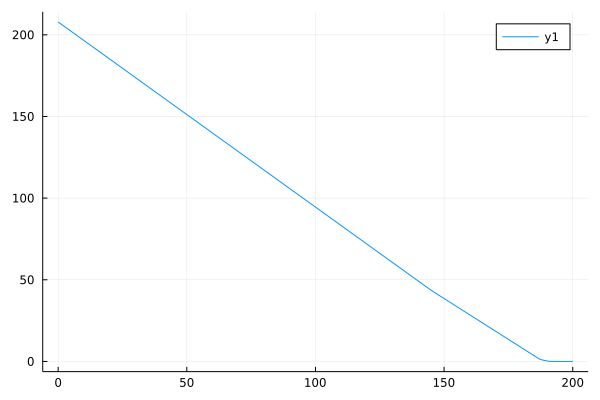

In [11]:
x=(0:200.0)

plot(x,piecewise_linear.(x,Ref(cuts1)))

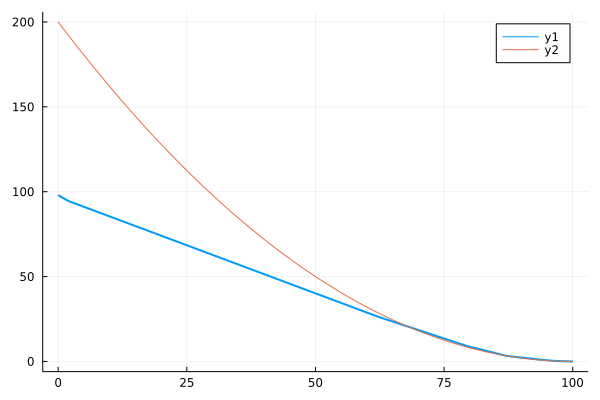

In [12]:
x=(0:100.0)

plot(x,piecewise_linear.(x,Ref(cuts2)),lw=2)
plot!(x,p3*(100 .-x).^2/200)

## Stochastic cutting plane v2

In [13]:
#array de vectores de cuts. Arranca en la lower bound
cuts1 = [[0.0;0.0]];
cuts2 = [[0.0;0.0]];

noises1 = Float64[]
noises2 = Float64[]


## Implemento SDDP a mano
@showprogress 1 for i=1:300
    
    ## FORWARD PASS
    #resuelvo el primer paso
    model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))
    @variable(model,u1>=0);
    @variable(model,x1>=0);
    @variable(model,z);

    @constraint(model,x1==x0+u1)
    
    for i=1:length(cuts1)
        cut=cuts1[i]
        @constraint(model,z>=cut[1]+cut[2]*x1);
    end

    
    @objective(model,Min,p1*u1+z);

    optimize!(model)

    global x1v = value.(x1);

    #sorteo una demanda de primer paso
    demand1 = rand(DiscreteUniform(0,100))
    push!(noises1,demand1)
    #resuelvo el segundo paso
    model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))
    @variable(model,u2>=0);
    @variable(model,x2>=0);
    @variable(model,z);

    @constraint(model,x2==x1v-demand1+u2)
    
    for i=1:length(cuts2)
        cut=cuts2[i]
        @constraint(model,z>=cut[1]+cut[2]*x2);
    end

    @objective(model,Min,p2*u2+z);

    optimize!(model)

    global x2v = value.(x2);
    
    println("x1:$x1v, x2: $x2v")
    
    ### BACKWARD PASS
    
    #sorteo la segunda demanda
    demand2 = rand(DiscreteUniform(0,100))
    push!(noises2,demand2)
    
    #resuelvo para todos los ruidos el ultimo paso y agrego un corte
    local_cuts1 = [];
    local_cuts2 = [];

    for i=1:length(noises2)
        
        demand2 = noises2[i]
        
        model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

        @variable(model,u3>=0);
        @variable(model,x2>=0);

        @constraint(model,x2+u3-demand2>=0);
        fix_x2 = @constraint(model,x2==x2v);

        @objective(model,Min,p3*u3);

        optimize!(model)

        beta = objective_value(model);
        lambda = dual(fix_x2)
        #println("fix_x2=$lambda")
        push!(local_cuts2,[beta-lambda*x2v;lambda])
    
        
        #resuelvo para todos los ruidos el segundo paso y agrego un corte
        demand1 = noises1[i]
        
        model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

        @variable(model,u2>=0);
        @variable(model,x1>=0);
        @variable(model,z);

        @constraint(model,x1+u2-demand1>=0);
        fix_x1 = @constraint(model,x1==x1v);

        for i=1:length(cuts2)
            cut=cuts2[i]
            @constraint(model,z>=cut[1]+cut[2]*(x1+u2-demand1));
        end

        @objective(model,Min,p2*u2+z);

        optimize!(model)

        beta = objective_value(model);
        lambda = dual(fix_x1)
        #println("fix_x1=$lambda")
        push!(local_cuts1,[beta-lambda*x1v;lambda])

    end
    
    cuts2 = (i-1)/i * cuts2
    push!(cuts2,mean(local_cuts2))
    cuts1 = (i-1)/i * cuts1
    push!(cuts1,mean(local_cuts1))    
    
end

x1:0.0, x2: 0.0
x1:68.0, x2: 42.0
x1:79.0, x2: 24.0
x1:0.0, x2: 62.5
x1:122.25, x2: 53.25
x1:158.6, x2: 106.6
x1:61.66666666666673, x2: 19.66666666666673
x1:95.31578947368422, x2: 86.31578947368422
x1:109.31372549019608, x2: 109.31372549019608
x1:124.20833333333341, x2: 93.20833333333341
x1:91.18115942028979, x2: 30.181159420289788
x1:99.72222222222211, x2: 51.0
x1:118.98594377510037, x2: 27.985943775100367
x1:140.4705882352941, x2: 66.47058823529409
x1:129.14532871972312, x2: 96.14532871972312
x1:112.39726027397248, x2: 47.166666666666664
x1:125.05935534591195, x2: 63.4
x1:146.21328903654492, x2: 93.21328903654492
x1:136.86761565836304, x2: 98.86761565836304
x1:134.37959183673502, x2: 92.37959183673502
x1:134.37959183673507, x2: 81.37959183673507
x1:0.0, x2: 0.0
x1:87.58830769230767, x2: 36.588307692307666
x1:105.70402700747536, x2: 58.999999999999986
x1:119.63558620689658, x2: 106.63558620689658
x1:130.21791044776117, x2: 68.21791044776117
x1:123.41652021089655, x2: 85.41652021089655

Progress:  10%|████▎                                    |  ETA: 0:00:10

x1:137.35527544351075, x2: 42.35527544351075
x1:123.10089020771498, x2: 45.0
x1:135.1212653778558, x2: 125.12126537785579
x1:132.0168361978252, x2: 85.0168361978252
x1:132.01683619782523, x2: 122.01683619782523
x1:132.01683619782517, x2: 78.01683619782517
x1:132.01683619782509, x2: 126.01683619782509
x1:132.0168361978251, x2: 104.01683619782511
x1:132.0168361978252, x2: 77.0168361978252
x1:132.01683619782514, x2: 90.01683619782514
x1:71.96517541591265, x2: 40.5
x1:99.85507491746378, x2: 57.92857142857143
x1:116.8286403357661, x2: 39.39999999999997
x1:134.16799722318626, x2: 132.16799722318626
x1:125.94913454390982, x2: 44.99999999999999
x1:135.90537306939316, x2: 53.905373069393164
x1:110.74589813097462, x2: 104.74589813097462
x1:124.85427498555745, x2: 100.85427498555745
x1:129.93766528145156, x2: 90.93766528145156
x1:129.9376652814514, x2: 55.93766528145139
x1:127.3804692454029, x2: 76.3804692454029
x1:136.1953097654886, x2: 114.19530976548859
x1:128.50277492291877, x2: 106.502774922

Progress:  19%|███████▉                                 |  ETA: 0:00:16

x1:125.18066378066374, x2: 96.18066378066374
x1:126.46522195036671, x2: 100.46522195036671
x1:126.46522195036668, x2: 87.46522195036668
x1:126.46522195036663, x2: 60.465221950366626
x1:126.46522195036682, x2: 106.46522195036682
x1:126.46522195036687, x2: 122.46522195036687
x1:126.46522195036694, x2: 60.46522195036694
x1:122.2178805876834, x2: 82.2178805876834
x1:127.42743382682843, x2: 86.42743382682843
x1:125.77347531461707, x2: 60.77347531461707


Progress:  23%|█████████▎                               |  ETA: 0:00:18

x1:122.27473393772365, x2: 106.27473393772365
x1:133.7092229484389, x2: 133.7092229484389
x1:129.19335817727287, x2: 111.19335817727287
x1:129.19335817727293, x2: 71.19335817727293
x1:129.1933581772729, x2: 110.1933581772729
x1:129.19335817727284, x2: 75.19335817727284
x1:129.19335817727287, x2: 102.19335817727287


Progress:  25%|██████████▎                              |  ETA: 0:00:20

x1:0.0, x2: 0.0
x1:80.48666372017975, x2: 32.511627906976706
x1:101.43449750147697, x2: 51.95454545454539
x1:114.26561304819617, x2: 68.91666666666663
x1:131.71251450234465, x2: 130.71251450234465
x1:122.79835934921638, x2: 76.79835934921638


Progress:  27%|███████████▏                             |  ETA: 0:00:21

x1:126.70086136613429, x2: 36.538461538461505
x1:136.03653054209423, x2: 58.036530542094226
x1:115.75516997167108, x2: 68.75516997167108
x1:127.06851742198054, x2: 54.068517421980545
x1:135.6901880599897, x2: 128.6901880599897


Progress:  29%|███████████▊                             |  ETA: 0:00:22

x1:131.64264859643947, x2: 42.538461538461554
x1:122.52211474907647, x2: 96.52211474907647
x1:126.01132767074292, x2: 117.01132767074292
x1:126.01132767074284, x2: 91.01132767074284
x1:126.01132767074289, x2: 75.01132767074289


Progress:  30%|████████████▍                            |  ETA: 0:00:23

x1:126.0113276707427, x2: 48.285714285714334
x1:119.33429636317103, x2: 75.33429636317103
x1:124.91469954934304, x2: 93.91469954934304
x1:128.76376684683402, x2: 55.76376684683402


Progress:  32%|█████████████                            |  ETA: 0:00:24

x1:123.30147204566684, x2: 107.30147204566684
x1:124.48869271621024, x2: 39.48869271621024
x1:129.27004923641755, x2: 57.27004923641755
x1:120.57086445155271, x2: 62.57086445155271


Progress:  33%|█████████████▌                           |  ETA: 0:00:24

x1:126.8488929342532, x2: 48.38461538461535
x1:119.87385549589271, x2: 98.87385549589271
x1:124.0466943463311, x2: 122.0466943463311
x1:124.04669434633098, x2: 93.04669434633098


Progress:  34%|██████████████▏                          |  ETA: 0:00:25

x1:124.046694346331, x2: 63.046694346330995
x1:124.04669434633107, x2: 43.50000000000015
x1:127.82123944468182, x2: 81.82123944468182
x1:125.45621990992161, x2: 94.45621990992161


Progress:  36%|██████████████▋                          |  ETA: 0:00:26

x1:124.08469135802048, x2: 53.200000000000024
x1:127.55206980676515, x2: 37.66666666666661
x1:108.72825984453398, x2: 45.64705882352941
x1:119.3732865709962, x2: 75.3732865709962


Progress:  37%|███████████████▏                         |  ETA: 0:00:26

x1:126.91924199693266, x2: 54.444444444444294
x1:119.28471677444517, x2: 59.28471677444517
x1:124.98427999006427, x2: 86.98427999006427
x1:129.6844000814107, x2: 83.6844000814107


Progress:  38%|███████████████▊                         |  ETA: 0:00:27

x1:127.7910016816325, x2: 126.7910016816325
x1:127.79100168163261, x2: 63.79100168163261
x1:127.79100168163285, x2: 49.999999999999964


Progress:  39%|████████████████▏                        |  ETA: 0:00:28

x1:119.55374334379513, x2: 42.553743343795134
x1:127.52732082225602, x2: 54.49999999999995
x1:120.22685855527708, x2: 94.22685855527708


Progress:  40%|████████████████▌                        |  ETA: 0:00:28

x1:124.79048717804453, x2: 49.33333333333326
x1:133.3419312064061, x2: 63.34193120640609
x1:124.55059483146827, x2: 68.55059483146827


Progress:  41%|█████████████████                        |  ETA: 0:00:28

x1:129.83197886893268, x2: 117.83197886893268
x1:128.38939105357602, x2: 97.38939105357602
x1:128.38939105357608, x2: 55.38939105357608


Progress:  42%|█████████████████▍                       |  ETA: 0:00:29

x1:128.389391053576, x2: 30.38939105357599
x1:116.02830487033381, x2: 87.02830487033381
x1:122.35121318353711, x2: 120.35121318353711


Progress:  43%|█████████████████▊                       |  ETA: 0:00:29

x1:125.15901988881001, x2: 108.15901988881001
x1:125.15901988881005, x2: 43.26666666666667
x1:130.34653252099767, x2: 107.34653252099767


Progress:  44%|██████████████████▏                      |  ETA: 0:00:30

x1:122.38571413419356, x2: 54.12500000000002
x1:127.60959624181915, x2: 49.69999999999996
x1:137.1115112241722, x2: 87.1115112241722


Progress:  45%|██████████████████▋                      |  ETA: 0:00:30

x1:116.14039463388741, x2: 54.33333333333326
x1:122.95257589984371, x2: 91.95257589984371
x1:126.4238406973164, x2: 71.4238406973164


Progress:  46%|███████████████████                      |  ETA: 0:00:30

x1:126.99131240986402, x2: 121.99131240986402
x1:125.12804944516115, x2: 124.12804944516115
x1:125.12804944516077, x2: 59.12804944516077


Progress:  47%|███████████████████▍                     |  ETA: 0:00:30

x1:125.12804944516068, x2: 96.12804944516068
x1:120.96135516974672, x2: 50.961355169746724
x1:124.90068130538225, x2: 107.90068130538225


Progress:  48%|███████████████████▉                     |  ETA: 0:00:31

x1:133.5747286265356, x2: 117.5747286265356
x1:129.96913931055087, x2: 72.96913931055087
x1:129.34065172726727, x2: 29.34065172726727


Progress:  49%|████████████████████▎                    |  ETA: 0:00:31

x1:121.51829739712815, x2: 81.51829739712815
x1:124.95382557027136, x2: 50.95382557027136
x1:128.3548746557041, x2: 107.3548746557041


Progress:  50%|████████████████████▋                    |  ETA: 0:00:31

x1:122.7980781039158, x2: 48.7980781039158
x1:127.05424478670788, x2: 54.05424478670788
x1:120.92575896122862, x2: 62.925758961228624


Progress:  51%|█████████████████████                    |  ETA: 0:00:31

x1:123.95083788414185, x2: 93.95083788414185
x1:123.95083788414185, x2: 96.95083788414185


Progress:  52%|█████████████████████▍                   |  ETA: 0:00:32

x1:123.95083788414186, x2: 70.95083788414186
x1:123.95083788414213, x2: 122.95083788414213


Progress:  53%|█████████████████████▋                   |  ETA: 0:00:32

x1:123.95083788414199, x2: 68.95083788414199
x1:123.95083788414213, x2: 62.95083788414213


Progress:  53%|█████████████████████▉                   |  ETA: 0:00:32

x1:123.950837884142, x2: 71.950837884142
x1:123.95083788414172, x2: 114.95083788414172


Progress:  54%|██████████████████████▏                  |  ETA: 0:00:32

x1:123.95083788414182, x2: 120.95083788414182
x1:123.95083788414176, x2: 67.95083788414176


Progress:  55%|██████████████████████▍                  |  ETA: 0:00:32

x1:123.9508378841417, x2: 44.950837884141706
x1:123.95083788414175, x2: 56.57692307692313


Progress:  55%|██████████████████████▋                  |  ETA: 0:00:32

x1:134.3106398165763, x2: 103.3106398165763
x1:128.6686609720221, x2: 91.66866097202211


Progress:  56%|███████████████████████                  |  ETA: 0:00:32

x1:126.05647262628983, x2: 51.07692307692325
x1:115.74573009756091, x2: 52.74573009756091


Progress:  57%|███████████████████████▎                 |  ETA: 0:00:32

x1:121.5356574299352, x2: 72.5356574299352
x1:125.11924607396618, x2: 45.57142857142854


Progress:  57%|███████████████████████▌                 |  ETA: 0:00:32

x1:132.89796947556107, x2: 132.89796947556107
x1:129.34887336915378, x2: 59.34887336915378


Progress:  58%|███████████████████████▊                 |  ETA: 0:00:32

x1:117.44083801612017, x2: 102.44083801612017
x1:121.38877209875255, x2: 49.89999999999989


Progress:  59%|████████████████████████                 |  ETA: 0:00:32

x1:126.5639657122573, x2: 55.5639657122573
x1:120.54609607879084, x2: 67.54609607879084


Progress:  59%|████████████████████████▍                |  ETA: 0:00:32

x1:123.87995703626773, x2: 92.87995703626773
x1:124.46590706253751, x2: 99.46590706253751


Progress:  60%|████████████████████████▋                |  ETA: 0:00:32

x1:124.46590706253802, x2: 41.40000000000001
x1:122.13117749660857, x2: 52.13117749660857


Progress:  61%|████████████████████████▉                |  ETA: 0:00:32

x1:127.51145497563756, x2: 99.51145497563756
x1:124.64331992581543, x2: 47.14285714285726


Progress:  61%|█████████████████████████▏               |  ETA: 0:00:32

x1:130.23956287711144, x2: 53.888888888888964
x1:123.78589176504306, x2: 52.78589176504306


Progress:  62%|█████████████████████████▍               |  ETA: 0:00:32

x1:128.31200768307605, x2: 58.31200768307605
x1:123.46222530218424, x2: 35.00000000000074


Progress:  63%|█████████████████████████▊               |  ETA: 0:00:32

x1:129.96136839400893, x2: 89.96136839400893
x1:127.39619387379244, x2: 67.39619387379244


Progress:  63%|██████████████████████████               |  ETA: 0:00:32

x1:126.36451445129511, x2: 88.36451445129511
x1:126.31128609717193, x2: 115.31128609717193


Progress:  64%|██████████████████████████▎              |  ETA: 0:00:32

x1:126.31128609717194, x2: 97.31128609717194
x1:126.31128609717223, x2: 103.31128609717223


Progress:  65%|██████████████████████████▌              |  ETA: 0:00:32

x1:126.31128609717238, x2: 124.31128609717238
x1:126.31128609717209, x2: 48.311286097172086


Progress:  65%|██████████████████████████▊              |  ETA: 0:00:32

x1:126.31128609717237, x2: 112.31128609717237
x1:126.31128609717203, x2: 87.31128609717203


Progress:  66%|███████████████████████████              |  ETA: 0:00:32

x1:126.311286097172, x2: 103.311286097172
x1:26.8051902507536, x2: 38.19047619047605


Progress:  67%|███████████████████████████▍             |  ETA: 0:00:31

x1:95.8938578293455, x2: 44.89473684210528
x1:110.28918909645637, x2: 58.28918909645637


Progress:  67%|███████████████████████████▋             |  ETA: 0:00:31

x1:119.09084230377084, x2: 108.09084230377084
x1:124.79368184390842, x2: 52.33333333333329


Progress:  68%|███████████████████████████▉             |  ETA: 0:00:31

x1:118.6192217358068, x2: 107.6192217358068
x1:121.71879781462218, x2: 41.71879781462218


Progress:  69%|████████████████████████████▏            |  ETA: 0:00:31

x1:126.55025614116289, x2: 123.55025614116289
x1:123.9972858641513, x2: 77.9972858641513


Progress:  69%|████████████████████████████▍            |  ETA: 0:00:31

x1:123.99728586415094, x2: 64.99728586415094
x1:121.50596864498276, x2: 83.50596864498276


Progress:  70%|████████████████████████████▊            |  ETA: 0:00:30

x1:123.89248474822779, x2: 67.89248474822779
x1:126.28508026716835, x2: 47.470588235294066


Progress:  71%|█████████████████████████████            |  ETA: 0:00:30

x1:119.60320755600787, x2: 77.60320755600787
x1:126.60428580132181, x2: 109.60428580132181


Progress:  71%|█████████████████████████████▎           |  ETA: 0:00:30

x1:123.89808838803808, x2: 114.89808838803808
x1:123.89808838803799, x2: 118.89808838803799


Progress:  72%|█████████████████████████████▌           |  ETA: 0:00:30

x1:123.89808838803798, x2: 123.89808838803798
x1:123.89808838803793, x2: 29.898088388037934


Progress:  73%|█████████████████████████████▊           |  ETA: 0:00:29

x1:123.89808838803788, x2: 60.89808838803788
x1:122.64110515177511, x2: 116.64110515177511


Progress:  73%|██████████████████████████████▏          |  ETA: 0:00:29

x1:120.89142839235647, x2: 78.89142839235647
x1:120.89142839235633, x2: 119.89142839235633


Progress:  74%|██████████████████████████████▍          |  ETA: 0:00:29

x1:120.89142839235625, x2: 41.648648648648624
x1:124.23537615396259, x2: 97.23537615396259


Progress:  75%|██████████████████████████████▋          |  ETA: 0:00:28

x1:115.96099612632266, x2: 62.960996126322655
x1:120.44840618400416, x2: 99.44840618400416


Progress:  75%|██████████████████████████████▉          |  ETA: 0:00:28

x1:122.08044380105845, x2: 99.08044380105845
x1:122.08044380105827, x2: 52.50000000000006


Progress:  76%|███████████████████████████████▏         |  ETA: 0:00:28

x1:125.66738936010991, x2: 57.66738936010991
x1:116.69766133629176, x2: 43.69766133629176


Progress:  77%|███████████████████████████████▍         |  ETA: 0:00:27

x1:122.2779016896634, x2: 54.277901689663395
x1:127.99649360764964, x2: 104.99649360764964


Progress:  77%|███████████████████████████████▊         |  ETA: 0:00:27

x1:125.1519081647254, x2: 51.1519081647254
x1:122.40464064836979, x2: 44.2727272727271


Progress:  78%|████████████████████████████████         |  ETA: 0:00:26

x1:128.26661246447827, x2: 82.26661246447827


Progress:  78%|████████████████████████████████▏        |  ETA: 0:00:26

x1:125.14297139932751, x2: 94.14297139932751


Progress:  79%|████████████████████████████████▎        |  ETA: 0:00:26

x1:124.12615756602237, x2: 109.12615756602237


Progress:  79%|████████████████████████████████▍        |  ETA: 0:00:26

x1:124.12615756602199, x2: 93.12615756602199


Progress:  79%|████████████████████████████████▌        |  ETA: 0:00:25

x1:124.126157566022, x2: 116.126157566022


Progress:  80%|████████████████████████████████▋        |  ETA: 0:00:25

x1:124.12615756602203, x2: 47.5833333333333


Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:25

x1:124.12615756602202, x2: 101.12615756602202


Progress:  80%|████████████████████████████████▉        |  ETA: 0:00:25

x1:124.12615756602162, x2: 48.12615756602162


Progress:  81%|█████████████████████████████████▏       |  ETA: 0:00:24

x1:107.03465601665657, x2: 29.03465601665657


Progress:  81%|█████████████████████████████████▎       |  ETA: 0:00:24

x1:115.91006491867843, x2: 76.91006491867843


Progress:  81%|█████████████████████████████████▍       |  ETA: 0:00:24

x1:121.6248486260535, x2: 120.6248486260535


Progress:  82%|█████████████████████████████████▌       |  ETA: 0:00:24

x1:127.43059073649287, x2: 111.43059073649287


Progress:  82%|█████████████████████████████████▋       |  ETA: 0:00:24

x1:118.87148461366411, x2: 81.87148461366411


Progress:  82%|█████████████████████████████████▊       |  ETA: 0:00:23

x1:118.87148461366426, x2: 40.71428571428566


Progress:  83%|█████████████████████████████████▉       |  ETA: 0:00:23

x1:122.284221523766, x2: 100.284221523766


Progress:  83%|██████████████████████████████████       |  ETA: 0:00:23

x1:118.49757439656031, x2: 50.33333333333339


Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:22

x1:121.60633033259484, x2: 43.00000000000004


Progress:  84%|██████████████████████████████████▎      |  ETA: 0:00:22

x1:133.71099483123356, x2: 100.71099483123356


Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:22

x1:128.08025089334117, x2: 68.08025089334117


Progress:  84%|██████████████████████████████████▋      |  ETA: 0:00:21

x1:125.17562087878242, x2: 95.17562087878242


Progress:  85%|██████████████████████████████████▊      |  ETA: 0:00:21

x1:108.6373560997843, x2: 99.6373560997843


Progress:  85%|██████████████████████████████████▉      |  ETA: 0:00:21

x1:115.80172249770658, x2: 47.066666666666855


Progress:  85%|███████████████████████████████████      |  ETA: 0:00:20

x1:121.0945354225439, x2: 98.0945354225439


Progress:  86%|███████████████████████████████████▏     |  ETA: 0:00:20

x1:127.58073531004432, x2: 33.5000000000003


Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:20

x1:122.06941284624274, x2: 117.06941284624274


Progress:  86%|███████████████████████████████████▍     |  ETA: 0:00:19

x1:124.48062219140364, x2: 96.48062219140364


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:19

x1:124.48062219140368, x2: 41.23684210526319


Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:19

x1:114.37264524399654, x2: 50.0


Progress:  87%|███████████████████████████████████▊     |  ETA: 0:00:18

x1:120.97949668104144, x2: 45.473684210526315


Progress:  88%|████████████████████████████████████     |  ETA: 0:00:18

x1:130.07120915168198, x2: 123.07120915168198


Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:17

x1:125.88473351525563, x2: 75.88473351525563


Progress:  88%|████████████████████████████████████▎    |  ETA: 0:00:17

x1:124.0457468418544, x2: 47.64285714285729


Progress:  89%|████████████████████████████████████▍    |  ETA: 0:00:17

x1:117.96823407164186, x2: 84.96823407164186


Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:16

x1:122.64287837045579, x2: 38.64287837045579


Progress:  89%|████████████████████████████████████▋    |  ETA: 0:00:16

x1:130.70106691079502, x2: 119.70106691079502


Progress:  90%|████████████████████████████████████▊    |  ETA: 0:00:15

x1:118.00620937984502, x2: 100.00620937984502


Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:15

x1:118.85287451081187, x2: 44.50000000000006


Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:14

x1:121.25988438112657, x2: 56.38095238095239


Progress:  91%|█████████████████████████████████████▏   |  ETA: 0:00:14

x1:127.65727758589844, x2: 49.88888888888891


Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:14

x1:116.6945540284537, x2: 101.6945540284537


Progress:  91%|█████████████████████████████████████▌   |  ETA: 0:00:13

x1:121.81644182179927, x2: 81.81644182179927


Progress:  92%|█████████████████████████████████████▋   |  ETA: 0:00:13

x1:124.33878471498362, x2: 47.33878471498362


Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:12

x1:119.77302277438638, x2: 94.77302277438638


Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:00:12

x1:122.35954173848555, x2: 41.66666666666665


Progress:  93%|██████████████████████████████████████   |  ETA: 0:00:11

x1:128.29066082538287, x2: 83.29066082538287


Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:11

x1:125.63604519220088, x2: 121.63604519220088


Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:10

x1:125.63604519220078, x2: 84.63604519220078


Progress:  94%|██████████████████████████████████████▍  |  ETA: 0:00:10

x1:125.63604519220077, x2: 47.31250000000014


Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:10

x1:124.09409528709631, x2: 78.09409528709631


Progress:  94%|██████████████████████████████████████▋  |  ETA: 0:00:09

x1:114.88470449283712, x2: 57.884704492837116


Progress:  95%|██████████████████████████████████████▉  |  ETA: 0:00:09

x1:119.77392149350369, x2: 110.77392149350369


Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:08

x1:121.66013081636963, x2: 112.66013081636963


Progress:  95%|███████████████████████████████████████▏ |  ETA: 0:00:08

x1:121.6601308163695, x2: 69.6601308163695


Progress:  96%|███████████████████████████████████████▎ |  ETA: 0:00:07

x1:121.6601308163697, x2: 66.6601308163697


Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:07

x1:127.5953962082882, x2: 41.66666666666655


Progress:  96%|███████████████████████████████████████▌ |  ETA: 0:00:06

x1:122.38059026513002, x2: 53.92857142857142


Progress:  97%|███████████████████████████████████████▋ |  ETA: 0:00:06

x1:129.03164828925907, x2: 81.03164828925907


Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:05

x1:121.42453908545231, x2: 47.689655172413815


Progress:  97%|███████████████████████████████████████▉ |  ETA: 0:00:04

x1:126.59242220906441, x2: 118.59242220906441


Progress:  98%|████████████████████████████████████████ |  ETA: 0:00:04

x1:122.11767015536067, x2: 52.41176470588226


Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:03

x1:125.58303234705707, x2: 106.58303234705707


Progress:  98%|████████████████████████████████████████▍|  ETA: 0:00:03

x1:124.09054798438615, x2: 58.09054798438615


Progress:  99%|████████████████████████████████████████▌|  ETA: 0:00:02

x1:121.96794004723674, x2: 86.96794004723674


Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:02

x1:121.96794004723604, x2: 49.96794004723604


Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:01

x1:123.68945378192004, x2: 44.79999999999989


Progress: 100%|████████████████████████████████████████▉|  ETA: 0:00:01

x1:131.30709274716745, x2: 86.30709274716745


Progress: 100%|█████████████████████████████████████████| Time: 0:02:54


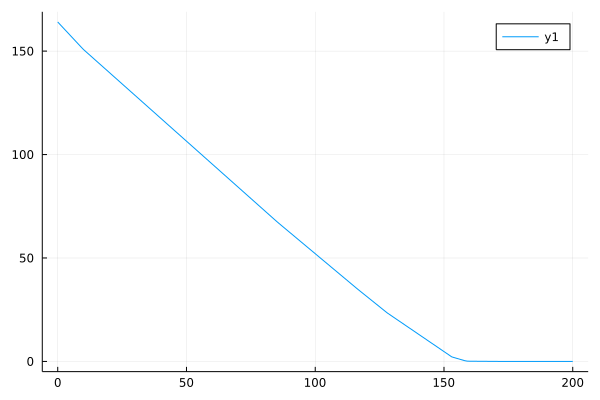

In [14]:
x=(0:200.0)

plot(x,piecewise_linear.(x,Ref(cuts1)))

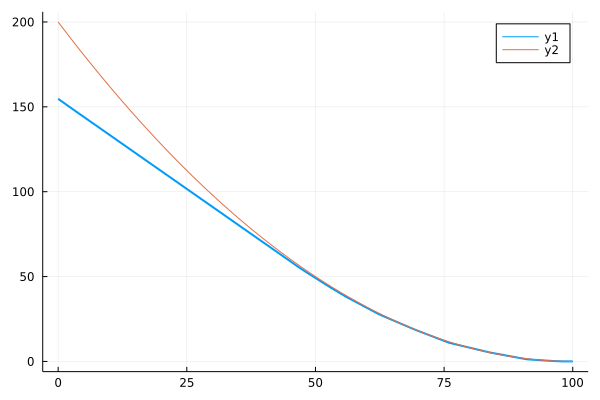

In [15]:
x=(0:100.0)

plot(x,piecewise_linear.(x,Ref(cuts2)),lw=2)
plot!(x,p3*(100 .-x).^2/200)